In [16]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from syd import make_viewer

from src.files import results_dir
from src.plotting import errorPlot
from src.iaf.source_population import SourcePopulationGabor
from src.iaf.analysis import (
    gather_metadata,
    gather_results,
    gather_rates,
    gather_weights,
    get_groupnames,
    sort_orientation_preference,
    summarize_weights,
)
from src.iaf.plotting import weights_to_gabor

In [17]:
experiment_folder = results_dir("iaf_runs") / "hofer" / "20250421"
metadata = gather_metadata(experiment_folder, experiment_type="hofer")
firing_rates = gather_rates(metadata, experiment_type="hofer")
weights = gather_weights(metadata, experiment_type="hofer", average_method="fraction", average_window=0.2, normalize=True)

In [18]:
results = gather_results(metadata)

In [19]:
orientation_preference = {sg: np.argmax(weights[sg], axis=-1) % 4 for sg in get_groupnames()}
weights_preferred = sort_orientation_preference(weights, orientation_preference["proximal"])

In [20]:
summary = summarize_weights(weights, orientation_preference["proximal"])

In [21]:
location_order = ["central", "edge", "outer"]
orientation_order = ["preferred", "other"]
weight_group_order = [f"{loc}-{ori}" for ori in orientation_order for loc in location_order]

In [40]:
summary["edge-preferred"].shape

(3, 5, 3, 10, 3)

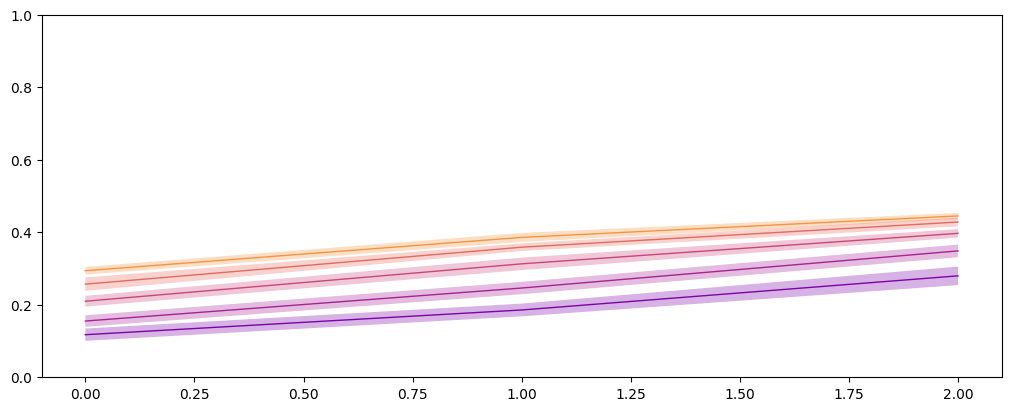

In [44]:
num_edges = len(metadata["edge_probabilities"])
num_ratios = len(metadata["dp_ratios"])
labels = [f"{(ii-1)*100:2g}" for ii in metadata["dp_ratios"]]
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

group = "distal-complex"
tuning = "edge-preferred"
reference_tuning = "central-preferred"
igroup = get_groupnames().index(group)
fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(10, 4), sharex=True, sharey=True)
for iratio in range(num_ratios):
    reference = summary[reference_tuning][igroup, iratio].reshape(num_edges, -1)
    data = summary[tuning][igroup, iratio].reshape(num_edges, -1)
    plot_data = data / (reference + data)
    errorPlot(range(num_edges), plot_data, axis=1, ax=ax, color=colors[iratio], linewidth=1.0, alpha=0.3)
ax.set_ylim(0, 1)
# ax.set_xticks(range(num_ratios), labels=labels)

plt.show()

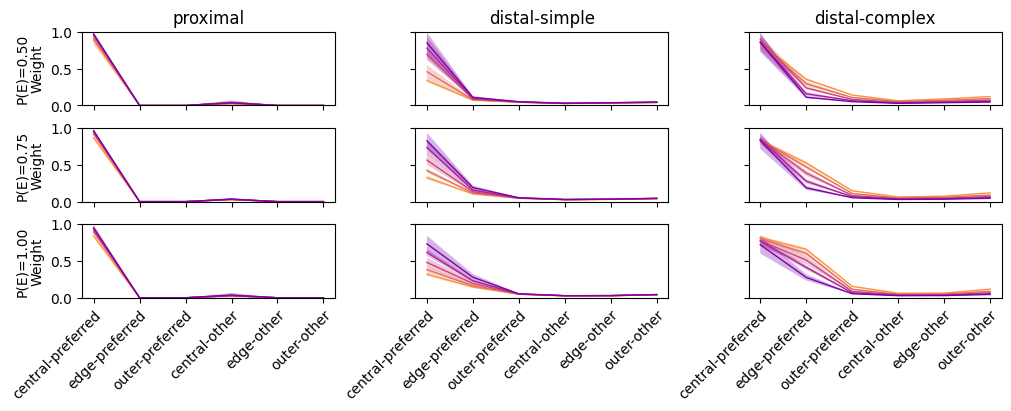

In [22]:
num_edges = len(metadata["edge_probabilities"])
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

fig, ax = plt.subplots(num_edges, 3, layout="constrained", figsize=(10, 4), sharex=True, sharey=True)
for iedge in range(num_edges):
    for igroup, sgname in enumerate(get_groupnames()):
        for iratio in range(num_ratios):
            data = np.stack([np.reshape(summary[wg][igroup, iratio, iedge], -1) for wg in weight_group_order])
            errorPlot(range(6), data, axis=1, ax=ax[iedge, igroup], color=colors[iratio], linewidth=1.0, alpha=0.3)
        ax[iedge, igroup].set_ylim(0, 1)

for igroup, sgname in enumerate(get_groupnames()):
    ax[0, igroup].set_title(sgname)
    ax[-1, igroup].set_xticks(range(len(weight_group_order)), labels=weight_group_order, rotation=45, ha="right", rotation_mode="anchor")
for iedge in range(num_edges):
    ax[iedge, 0].set_ylabel(f"P(E)={metadata['edge_probabilities'][iedge]:.2f}\nWeight")

plt.show()

In [14]:
def plot(state):
    dpratio = state["dpratio"]
    edge = state["edge"]
    simulation = state["simulation"]
    neuron = state["neuron"]
    spacing = state["spacing"]
    vmax = state["vmax"]

    proximal_gabor = weights_to_gabor(weights["proximal"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)
    simple_gabor = weights_to_gabor(weights["distal-simple"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)
    complex_gabor = weights_to_gabor(weights["distal-complex"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
    ax[0].imshow(proximal_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[0].set_title(f"{np.max(proximal_gabor)}")
    ax[1].imshow(simple_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[1].set_title(f"{np.max(simple_gabor)}")
    ax[2].imshow(complex_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[2].set_title(f"{np.max(complex_gabor)}")
    return fig

viewer = make_viewer(plot)
viewer.add_integer("dpratio", min=0, max=4)
viewer.add_integer("edge", min=0, max=2)
viewer.add_integer("simulation", min=0, max=9)
viewer.add_integer("neuron", min=0, max=2)
viewer.add_integer("spacing", value=2, min=0, max=10)
viewer.add_float("vmax", value=0.5, min=0.0, max=1.0)
viewer.show()

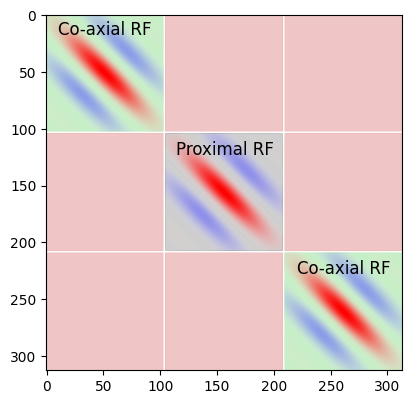

In [27]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from src.iaf.plotting import create_gabor, create_gabor_grid, gabor_rgba
from src.iaf.source_population import SourcePopulationGabor

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")

spacing = 2
halfsize = 51   
vmax_scale = 1.35


central_stimulus = 0
central_orientation = SourcePopulationGabor.orientations[central_stimulus]
stimulus = SourcePopulationGabor.make_stimulus(edge_probability=1.0, center_orientation=central_stimulus)
gabor_grid = create_gabor_grid(stimulus, spacing=spacing, gabor_params=dict(halfsize=halfsize), center_only=True)[0]
vmax = np.max(np.abs(gabor_grid)) * vmax_scale
gabor_grid = gabor_grid / vmax
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = mpl.colormaps["bwr"]
rgba_grid = cmap(norm(gabor_grid))
width = int(gabor_grid.shape[0] - 2 * spacing) // 3
(edge1x, edge1y), (edge2x, edge2y) = SourcePopulationGabor.stimulus_to_edge_positions(central_stimulus)

for i in range(3):
    for j in range(3):
        if i == 1 and j == 1:
            background_color = np.array([0.35, 0.35, 0.35, 0.3])
        elif (i == edge1x and j == edge1y) or (i == edge2x and j == edge2y):
            background_color = np.array([0.25, 0.8, 0.25, 0.3])
        else:
            background_color = np.array([0.8, 0.25, 0.25, 0.3])
        for ii in range(width):
            for jj in range(width):
                rgba_grid[i*(width+spacing)+ii, j*(width+spacing)+jj] = background_color

coaxial_gabor = create_gabor(central_orientation, halfsize=halfsize, envelope=0.4, width=0.6)
needed_vertical = gabor_grid.shape[0] - coaxial_gabor.shape[0]
needed_horizontal = gabor_grid.shape[1] - coaxial_gabor.shape[1]
coaxial_gabor_1 = np.vstack([coaxial_gabor, np.full((needed_vertical, coaxial_gabor.shape[1]), np.nan)])
coaxial_gabor_1 = np.hstack([coaxial_gabor_1, np.full((gabor_grid.shape[0], needed_horizontal), np.nan)])
rgba_1 = gabor_rgba(coaxial_gabor_1)

coaxial_gabor_2 = np.vstack([np.full((needed_vertical, coaxial_gabor.shape[1]), np.nan), coaxial_gabor])
coaxial_gabor_2 = np.hstack([np.full((gabor_grid.shape[0], needed_horizontal), np.nan), coaxial_gabor_2])
rgba_2 = gabor_rgba(coaxial_gabor_2)


proximal_gabor = np.vstack([np.full((width + spacing, coaxial_gabor.shape[1]), np.nan), coaxial_gabor, np.full((width + spacing, coaxial_gabor.shape[1]), np.nan)])
proximal_gabor = np.hstack([np.full((proximal_gabor.shape[0], width + spacing), np.nan), proximal_gabor, np.full((proximal_gabor.shape[0], width + spacing), np.nan)])
rgba_proximal = gabor_rgba(proximal_gabor)

ax.imshow(rgba_grid, interpolation="bilinear")
ax.imshow(rgba_1, interpolation="bilinear")
ax.imshow(rgba_2, interpolation="bilinear")
ax.imshow(rgba_proximal, interpolation="bilinear")
central_text_x = width + spacing + width / 2
central_text_y = width + spacing + width / 20
edge1_text_x = edge1x * (width + spacing) + width / 2
edge1_text_y = edge1y * (width + spacing) + width / 20
edge2_text_x = edge2x * (width + spacing) + width / 2
edge2_text_y = edge2y * (width + spacing) + width / 20
ax.text(central_text_x, central_text_y, "Proximal RF", ha="center", va="top", fontsize=12)
ax.text(edge1_text_x, edge1_text_y, "Co-axial RF", ha="center", va="top", fontsize=12)
ax.text(edge2_text_x, edge2_text_y, "Co-axial RF", ha="center", va="top", fontsize=12)
plt.show()